In [2]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [4]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        society_and_medicine =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


In [7]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares,  abs_pos_neg_ratio)

head(tidy_data)

Genre,Day_Of_Week,shares,abs_pos_neg_ratio
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,3.606061
business,monday,711,6.644338
business,monday,1500,6.375000
entertainment,monday,1200,2.088008
technology,monday,505,11.490024
technology,monday,855,1.977800


In [8]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)

day_table <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio))
day_table
#grouped by the day of the week so we can summarize the total amount of articles of that day of the week, the average shares of that day of the week, and the positive to negative word ratio of that day of the week

genre_table <- publishing_train %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
genre_table
#grouped by the genre so we can summarize the total articles from that genre, the average shares of that genre and the positive to negative word ratio of that genre

Genre,Day_Of_Week,shares,abs_pos_neg_ratio
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,3.606061
business,monday,711,6.644338
entertainment,monday,1200,2.088008
technology,monday,855,1.977800
technology,monday,891,9.748504
world,monday,710,1.611429


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos_neg_ratio
<fct>,<int>,<dbl>,<dbl>
monday,3295,3369.657,5.527280
tuesday,3507,2792.080,5.669865
wednesday,3664,2879.380,5.576851
thursday,3517,2894.013,5.668340
friday,2732,2793.846,5.350205
saturday,1142,3364.944,6.424908
sunday,1251,3531.652,5.797623


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos_neg_ratio
<fct>,<int>,<dbl>,<dbl>
entertainment,4015,2974.835,4.900262
business,3541,3265.274,6.739769
technology,4146,3178.463,6.982449
lifestyle,1237,3771.733,6.353915
world,4799,2318.699,3.780453
society_and_medicine,1370,3678.478,6.701515


In [9]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 

share_recipe <- recipe(shares ~ ., data = publishing_train) %>%
       step_scale(-shares, -Day_Of_Week, -Genre) %>%
       step_center(-shares, -Day_Of_Week, -Genre)



In [10]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)


share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 1:250)

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.558114e+04,5,5.535989e+02,Model001
1,rsq,standard,8.176047e-04,5,7.892010e-04,Model001
2,rmse,standard,1.349556e+04,5,5.910703e+02,Model002
2,rsq,standard,3.007263e-04,5,2.982816e-04,Model002
3,rmse,standard,1.264452e+04,5,9.035764e+02,Model003
3,rsq,standard,2.704466e-04,5,1.856772e-04,Model003
4,rmse,standard,1.240359e+04,5,1.082782e+03,Model004
4,rsq,standard,4.099186e-04,5,1.697453e-04,Model004
5,rmse,standard,1.219572e+04,5,1.150606e+03,Model005


In [11]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
232,rmse,standard,10871.05,5,1666.559,Model232


In [12]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.099041e+03
rsq,standard,2.363218e-03
mae,standard,2.459652e+03


In [19]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 7, repr.plot.height = 7)

share_plot <- ggplot(share_preds, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio")+
  geom_line(data = share_preds, aes(x = abs_pos_neg_ratio, y = .pred), color = "blue")+
  facet_grid(Genre ~ Day_Of_Week)+
  ggtitle("Shares by Pos Neg Ratio")

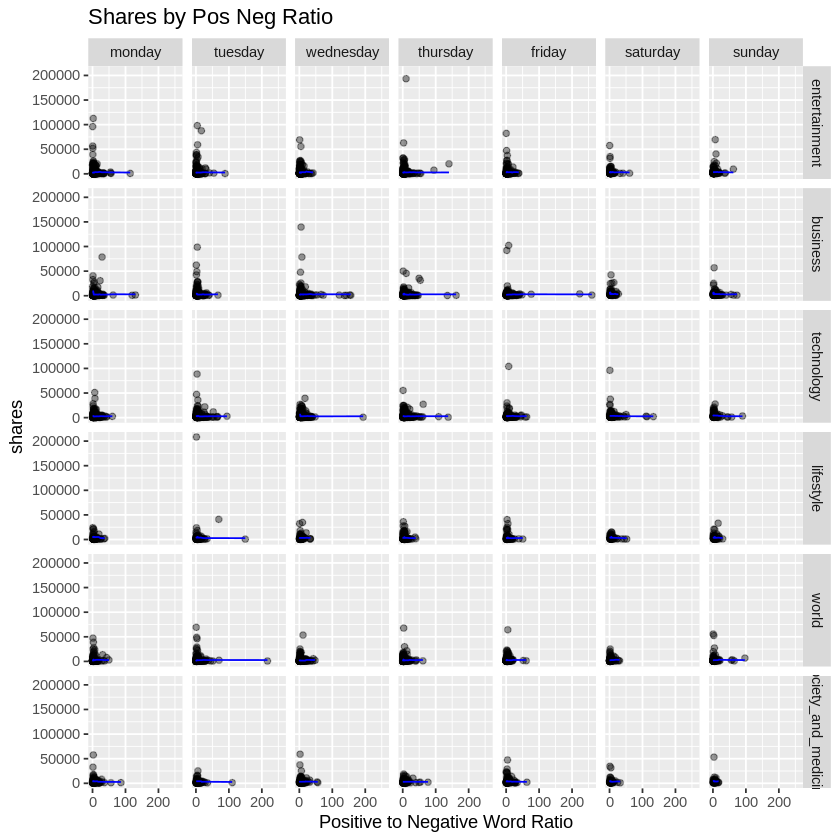

In [20]:
share_plot